In [4]:
import sys 
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from utils import *

## Create Kernels fro convolution 

In [5]:
import numpy.random
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
import scipy 

from elephant.kernels import ExponentialKernel,GaussianKernel
from elephant.statistics import time_histogram, instantaneous_rate
from quantities import ms, s, Hz
import quantities as pq
from neo.core import SpikeTrain
from quantities import s


def gaussian( x , sigma):
    return 1./np.sqrt( 2. * np.pi * sigma**2 ) * np.exp( -x**2 / ( 2. * sigma**2 ) )

def causal(x, alpha):
    return np.exp(alpha*x)

def exponential_kernel(x, tau):
  """
  Creates an exponential kernel with a decay constant.

  Args:
      t: Time values for the kernel (array-like).
      tau: Time shift for the kernel (float).
      decay_constant: Positive constant controlling the decay rate (default 1).

  Returns:
      A NumPy array representing the exponential kernel.
  """
  return scipy.stats.expon.pdf(x, loc=-10, scale=tau)
#convolution
def smooth_gaussian(y,box_pts): 
    x = (np.linspace(-box_pts/2.,box_pts/2.,box_pts + 1)) #Gaussian centred on 0
    std_norm = 2. #3. is an arbitrary value for normalizing the sigma
    sigma = box_pts/std_norm 
    integral = quad(gaussian, x[0], x[-1], args=(sigma))[0]
    box = gaussian(x, sigma)/integral

    y_smooth = np.convolve(y,box,mode='same')
    return y_smooth

def smooth_exp(spikes,tau): 

    train = SpikeTrain(spikes/20*ms, t_stop=360*1000,units=ms)
    inst_fr = instantaneous_rate(train, sampling_period=1/20*ms,center_kernel=False, kernel=ExponentialKernel(tau*ms))
    return np.hstack(inst_fr.__array__())

def smooth_gaussian_e(spikes,tau): 

    train = SpikeTrain(spikes/20*ms, t_stop=360*1000,units=ms)
    inst_fr = instantaneous_rate(train, sampling_period=1/20*ms,center_kernel=True, kernel=GaussianKernel(tau*ms))
    return np.hstack(inst_fr.__array__())



In [3]:
## TODO -check the kernel function 
kernel = ExponentialKernel(100*ms)
analogsignal()
kernel()

NameError: name 'analogsignal' is not defined

# Inhibitory cells
 A whole-cell recording database of neuromodulatory action in the adult neocortex Xuan Yan, Niccolo Calcini, Payam Safavi, Asli Ak, Koen Kole, Fleur Zeldenrust, Tansu Celikel
bioRxiv 2022.01.12.476007; doi: https://doi.org/10.1101/2022.01.12.476007)

In [627]:

path = "G:/My Drive/Analyzed/asli_1-18-7-19_E2_analyzed.mat"
data = loadmatInPy(path)

In [3]:
for i in data:
    print(i['input_generation_settings']['condition'])

ACSF
M1-ago
M1-ant


In [4]:
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

def return_partitioned_data(data,partitions,clean = True):
    input_settings = data['input_generation_settings']
    total_length = len(data['membrane_potential'])
    V = data['membrane_potential']
    I = data['input_current']
    h = data['hidden_state']
    thresholds = data['thresholds']
    if clean:
        idx = ~np.isnan(thresholds)
        thresholds = thresholds[idx]
        spks_acsf = data['spikeindices'][idx]
        threshold_idx = data['thresholdindices'][idx]
    else:
        # idx = ~np.isnan(thresholds)
        thresholds = thresholds
        spks_acsf = data['spikeindices']
        threshold_idx = data['thresholdindices']

    data_partitions = []

    for i in range(partitions):
        V_ = V[(total_length//partitions)*i:(total_length//partitions)*(i+1)]
        I_ = I[(total_length//partitions)*i:(total_length//partitions)*(i+1)]
        h_ = h[(total_length//partitions)*i:(total_length//partitions)*(i+1)]
        idx_temp = np.where((spks_acsf>=((total_length//partitions)*(i)))&(spks_acsf<((total_length//partitions)*(i+1))))
        spks_ = spks_acsf[idx_temp]-((i)*total_length//partitions)

        thresholds_ = thresholds[idx_temp]
        threshold_idx_ = threshold_idx[idx_temp]-((i)*total_length//partitions)

        data_idx = {'membrane_potential':V_,
                    'input_current':I_,
                    'hidden_state':h_,
                    'spikeindices':spks_,
                    'thresholds':thresholds_,
                    'thresholdindices':threshold_idx_,
                    'input_generation_settings':input_settings,
                    'firing_rate':len(spks_)*(input_settings['sampling_rate']*1000)/(total_length//partitions)
                    }
        data_partitions.append(data_idx)

    return data_partitions


In [5]:
part_data = return_partitioned_data(data[1],36000,clean=False)

In [631]:
time = 360*20000
h = data[1]['hidden_state'][:]
I = data[1]['input_current'][:]
spikes = data[1]['spikeindices'][:]
V = data[1]['membrane_potential'][:]


In [632]:
len(spikes)/360

8.061111111111112

## Make binary spike trains

In [11]:
binary_spikes = np.zeros(len(V))
binary_spikes[spikes] =1 

binary_spikes_nan = np.zeros(len(V))*np.nan
binary_spikes_nan[spikes] =1

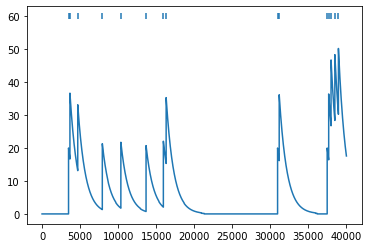

In [26]:
plt.scatter(np.arange(len(binary_spikes_nan[:20000*2])),binary_spikes_nan[:20000*2]*60,marker='|')
plt.plot(smooth_exp(spikes,50)[:20000*2])

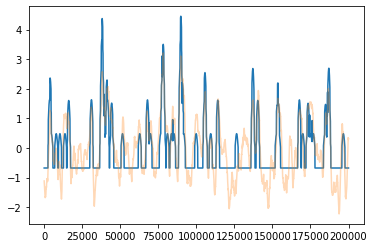

In [28]:
def standardize(data):
    return (data-np.mean(data))/np.std(data)

input_smooth = smooth_gaussian(I,100*20)
fr_gaussian = smooth_gaussian(binary_spikes,100*20)
plt.plot(standardize(fr_gaussian[:20000*10]))
plt.plot(standardize(input_smooth[:20000*10]),alpha=0.3)


In [29]:
tau = 100
train = SpikeTrain(spikes/20*ms, t_stop=360*1000,units=ms)
inst_fr = instantaneous_rate(train, sampling_period=1/20*ms, kernel=GaussianKernel(tau*ms))

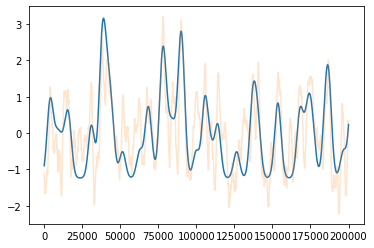

In [34]:
plt.plot(standardize(inst_fr[:20000*10]))
plt.plot(standardize(input_smooth[:20000*10]),alpha=0.2)
# plt.plot(standardize(fr_gaussian[:20000*10]),alpha=0.2)


In [35]:
cust_time_winds =[10,50,np.arange(100,600,100)]
cust_time_winds = np.hstack(cust_time_winds)


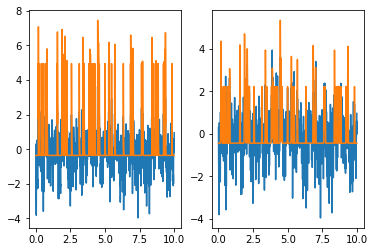

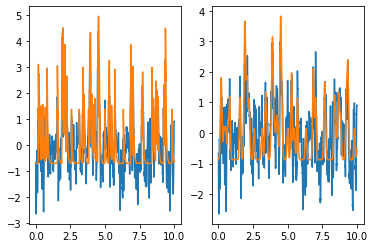

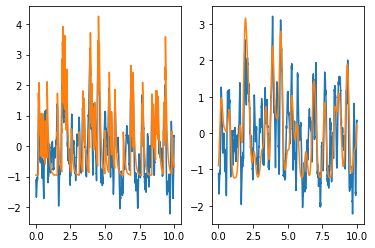

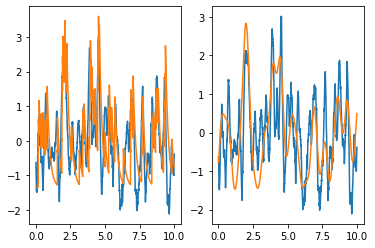

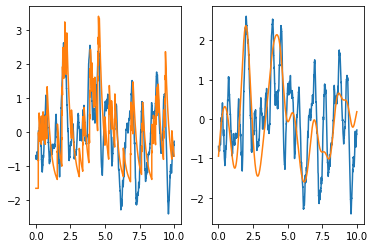

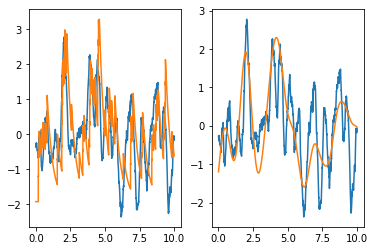

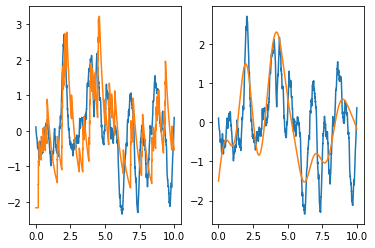

In [36]:
def standardize(data):
    return (data-np.mean(data))/np.std(data)
I_convs = []
fr_convs_exps = []
fr_convs_gaussian = []
h_convs = []
for i in cust_time_winds:
    fig,[ax1,ax2] = plt.subplots(1,2)
    box_size = i*20
    spikes_smooth = smooth_exp(spikes,i)
    spikes_smooth_g = smooth_gaussian_e(spikes,i)

    input_smooth = smooth_gaussian(I,box_size)
    h_smooth = smooth_gaussian(h,box_size)

    I_convs.append(input_smooth)
    fr_convs_exps.append(spikes_smooth)
    fr_convs_gaussian.append(spikes_smooth)
    h_convs.append(h_smooth)
    x = np.linspace(0,10,10*20000)
    ax1.plot(x,standardize(input_smooth[:10*20000]))
    ax1.plot(x,standardize(spikes_smooth[:10*20000]))
    ax2.plot(x,standardize(input_smooth[:10*20000]))
    ax2.plot(x,standardize(spikes_smooth_g[:10*20000]))    
    plt.show()


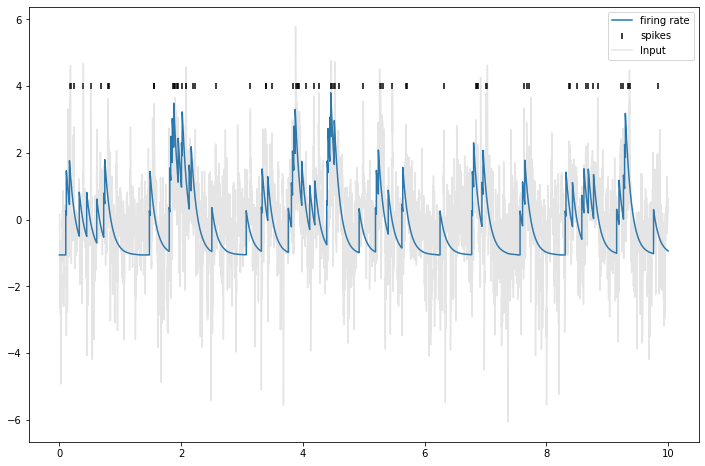

In [244]:
time = 10
x = np.linspace(0,10,10*20000)
plt.figure(figsize=[12,8])
plt.plot(x,(standardize(fr_convs[2]))[:time*20000])
plt.scatter(x, binary_spikes_nan[:time*20000]*4,c='black',marker="|")
plt.plot(x,(standardize(I))[:time*20000],c='grey',alpha=0.2)
plt.legend(['firing rate','spikes','Input'])
plt.show()

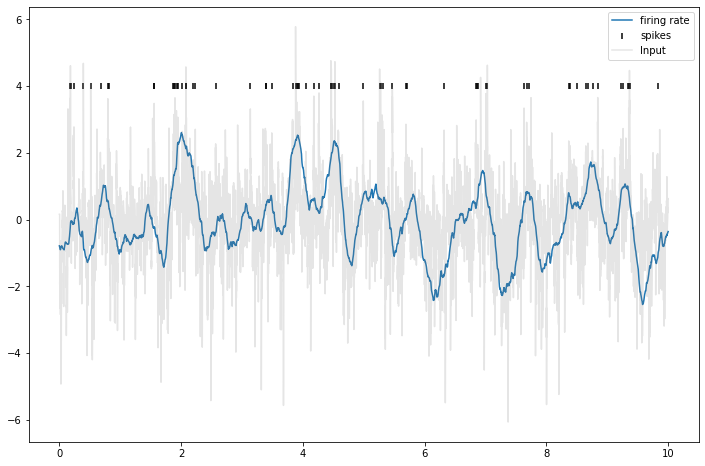

In [70]:
time = 10
x = np.linspace(0,10,10*20000)
plt.figure(figsize=[12,8])
plt.plot(x,(standardize(I_convs[2]))[:time*20000])
plt.scatter(x, binary_spikes_nan[:time*20000]*4,c='black',marker="|")
plt.plot(x,(standardize(I))[:time*20000],c='grey',alpha=0.2)
plt.legend(['firing rate','spikes','Input'])
plt.show()

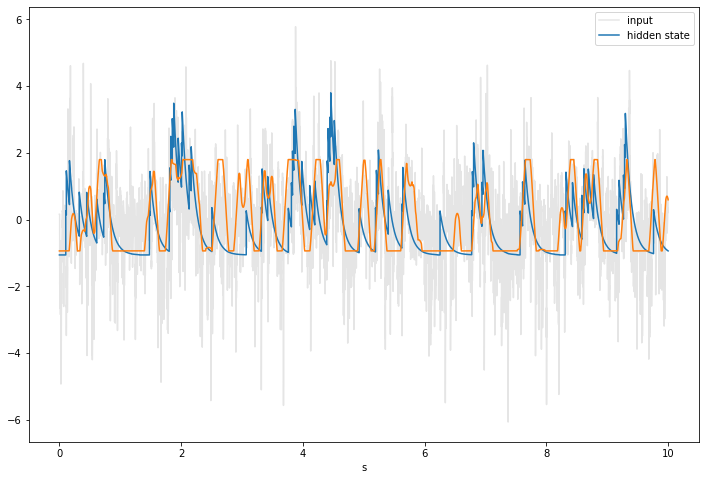

In [72]:
time = 10
x = np.linspace(0,10,10*20000)
plt.figure(figsize=[12,8])
plt.plot(x,standardize(I)[:time*20000],c='grey',alpha=0.2)
plt.plot(x,standardize(fr_convs[0])[:time*20000])
plt.plot(x,standardize(h_convs[0])[:time*20000])
plt.legend(['input','hidden state'],)
plt.xlabel('s')
plt.show()

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


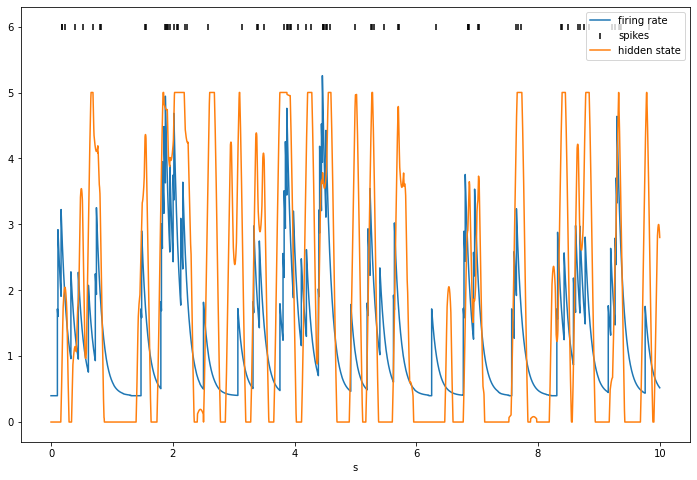

In [73]:
time = 10
x = np.linspace(0,10,10*20000)
plt.figure(figsize=[12,8])
plt.plot(x,standardize(fr_convs[0])[:time*20000]-min(standardize(fr_convs[1])[:time*20000]))
plt.scatter(x,binary_spikes_nan[:time*20000]*6,c='black',marker="|")
plt.plot(x,h_convs[0][:time*20000]*5)
plt.legend(['firing rate','spikes','hidden state'],)
plt.xlabel('s')
plt.show()

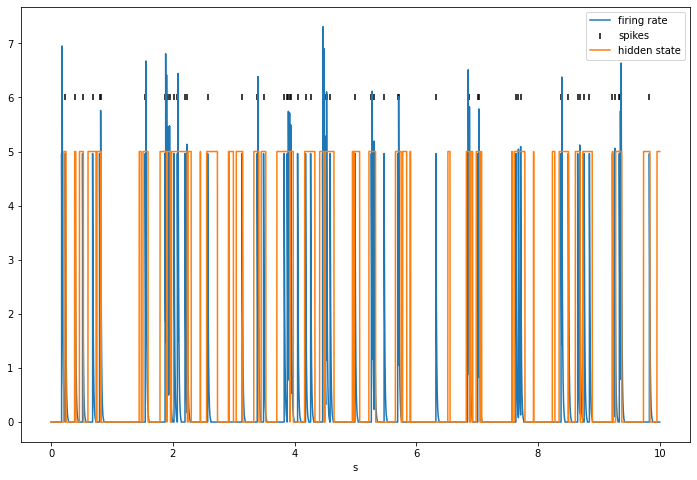

In [111]:
time = 10
x = np.linspace(0,time,time*20000)
plt.figure(figsize=[12,8])
plt.plot(x,standardize(fr_convs_exps[0])[:time*20000]-min(standardize(fr_convs_exps[0])[:time*20000]))
plt.scatter(x,binary_spikes_nan[:time*20000]*6,c='black',marker="|")
plt.plot(x,h[:time*20000]*5)
plt.legend(['firing rate','spikes','hidden state'],)
plt.xlabel('s')
plt.show()

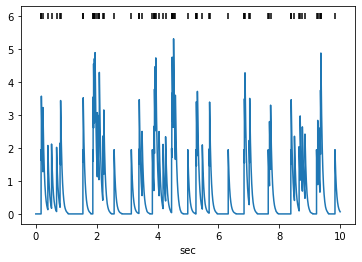

In [46]:
time = 10
x = np.linspace(0,360,360*20000)
plt.plot(x[:time*20000],standardize(fr_convs_exps[1])[:time*20000]-min(standardize(fr_convs_exps[1])[:time*20000]))
plt.scatter(x[:time*20000], binary_spikes_nan[:time*20000]*6,c='black',marker="|")
plt.xlabel('sec')
plt.show()


filter duration 10 ms


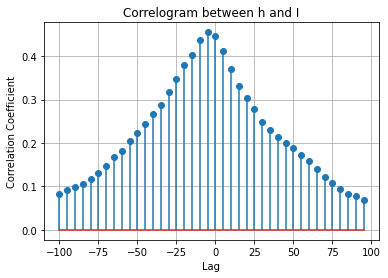

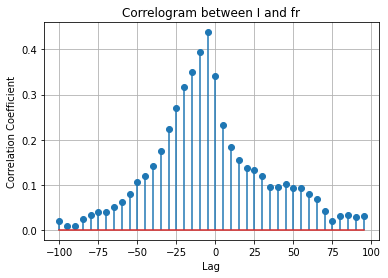

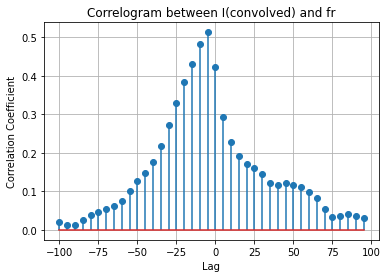

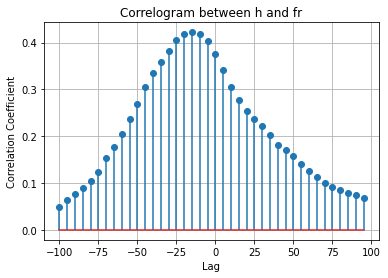

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Sample signals (replace with your actual data)
def plot_correlations(sig1,sig2,tau,str1,str2,ax):
    signal1 = sig1-np.mean(sig1)
    signal2 = sig2-np.mean(sig2)
    # Calculate cross-correlation with maximum lag of 20
    correlation = signal.correlate(signal1, signal2 , mode='full')
    correlation /= np.sqrt(np.sum(signal1**2)*np.sum(signal2**2))    
    lags = signal.correlation_lags(len(signal1), len(signal1))

    # Plot the correlogram
    # lags = np.arange(-tau,tau,1/20)
    # plt.stem(lags[::100], correlation[len(correlation)//2-tau*20:len(correlation)//2+tau*20][::100])
    ax.stem(lags[len(lags)//2-100*20:len(lags)//2+100*20:100]/20, correlation[len(lags)//2-100*20:len(lags)//2+100*20:100])

    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Correlogram between {str1} and {str2}')
    ax.grid(True)
    # plt.show()


print('filter duration '+str(10)+' ms')

# plot_correlations()
time_t = 20
fig,ax = plt.subplots()
plot_correlations(h[:time_t*20000],I[:time_t*20000],100,'h','I',ax)
fig,ax = plt.subplots()
plot_correlations(I[:time_t*20000],np.hstack(fr_convs_exps[0][:time_t*20000]),100,'I','fr',ax)
fig,ax = plt.subplots()
plot_correlations(I_convs[0][:time_t*20000],np.hstack(fr_convs_exps[0][:time_t*20000]),100,'I(convolved)','fr',ax)
fig,ax = plt.subplots()
plot_correlations(h[:time_t*20000],np.hstack(fr_convs_exps[0][:time_t*20000]),100,'h','fr',ax)

# plot_correlations(h[:10*20000],I[:10*20000],100,'h','I')

filter duration 10 ms


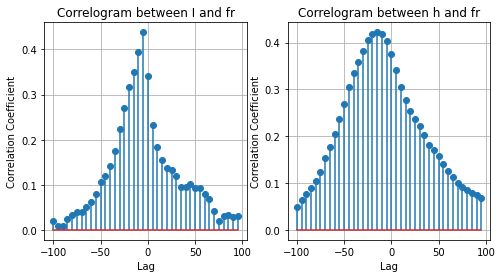

filter duration 50 ms


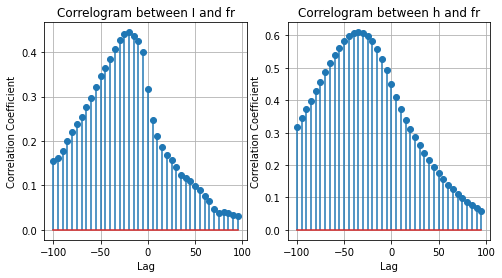

filter duration 100 ms


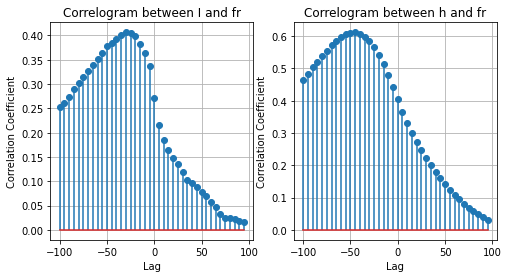

filter duration 200 ms


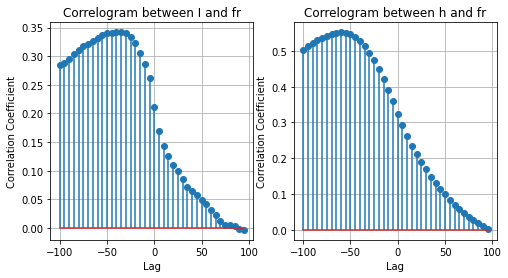

filter duration 300 ms


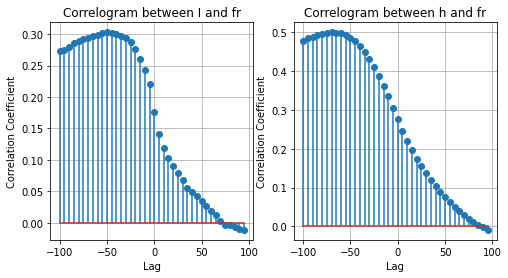

filter duration 400 ms


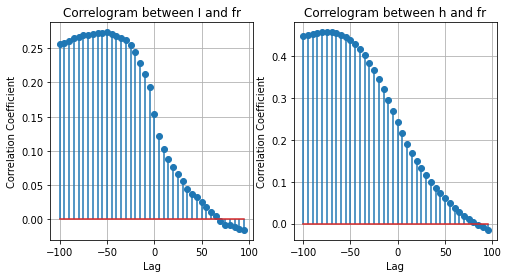

filter duration 500 ms


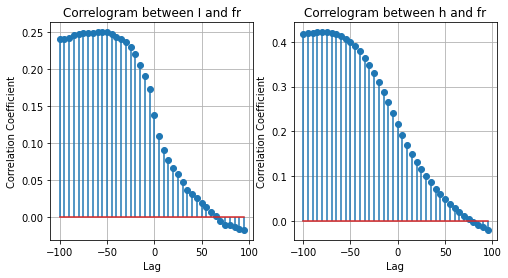

In [67]:
time_t = 20
for i in range(len(fr_convs_exps)):
    print('filter duration '+str(cust_time_winds[i])+' ms')
    fig,[ax1,ax2] = plt.subplots(1,2,figsize=[8,4])
    plot_correlations(I[:time_t*20000],np.hstack(fr_convs_exps[i][:time_t*20000]),100,'I','fr',ax1)
    # plot_correlations(I_convs[0][:time_t*20000],np.hstack(fr_convs_exps[0][:time_t*20000]),100,'I(convolved)','fr')
    plot_correlations(h[:time_t*20000],np.hstack(fr_convs_exps[i][:time_t*20000]),100,'h','fr',ax2)
    plt.show()

filter duration 10 ms


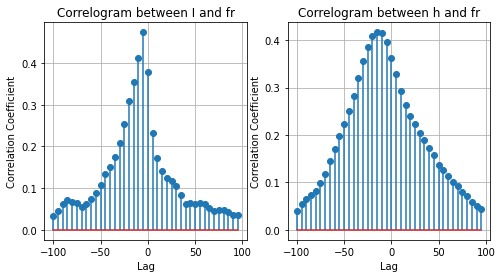

filter duration 50 ms


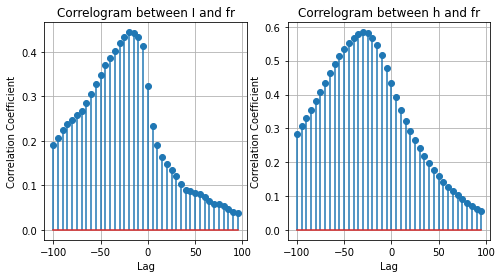

filter duration 100 ms


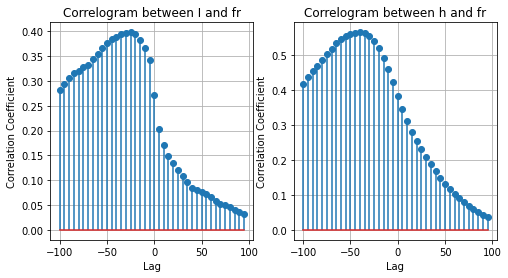

filter duration 200 ms


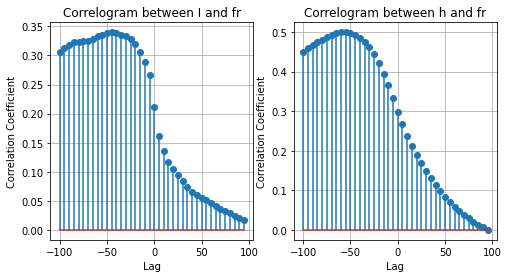

filter duration 300 ms


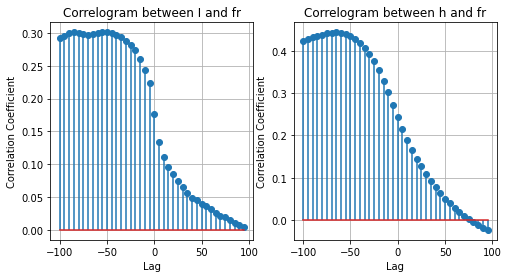

filter duration 400 ms


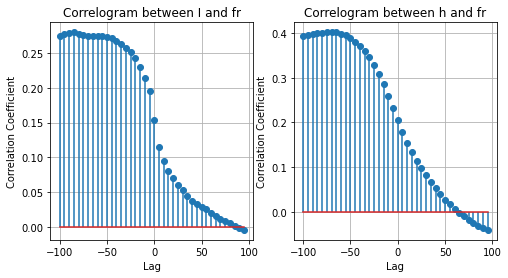

filter duration 500 ms


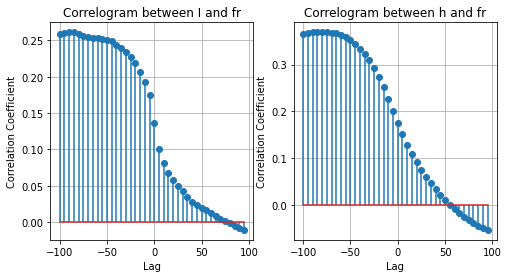

In [103]:
time_t = 20
for i in range(len(fr_convs_exps)):
    print('filter duration '+str(cust_time_winds[i])+' ms')
    fig,[ax1,ax2] = plt.subplots(1,2,figsize=[8,4])
    plot_correlations(I[-time_t*20000:],np.hstack(fr_convs_exps[i][-time_t*20000:]),100,'I','fr',ax1)
    # plot_correlations(I_convs[0][-time_t*20000:],np.hstack(fr_convs_exps[0][-time_t*20000:]),100,'I(convolved)','fr')
    plot_correlations(h[-time_t*20000:],np.hstack(fr_convs_exps[i][-time_t*20000:]),100,'h','fr',ax2)
    plt.show()

## forward correlations

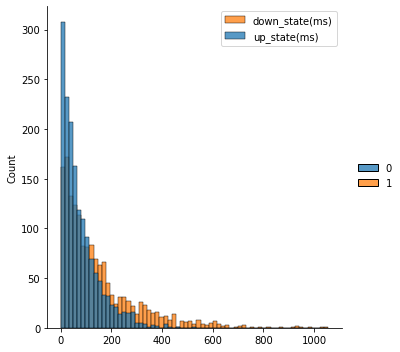

In [318]:
h = np.array(h,dtype=np.int32)
ups = np.where(np.diff(h)==1)[0]+1
downs = np.where(np.diff(h)==-1)[0]+1

up_durations = (downs-ups[:-1])/20
down_durations = (ups[1:] - downs)/20

sns.displot([up_durations,down_durations],log_scale=False,kind='hist')
plt.legend(['down_state(ms)','up_state(ms)'])
# sns.displot(,log_scale=False,kind='hist')

In [360]:


idx_up_h_50 = ups[np.where(up_durations>50)]
idx_down_h_50 = downs[np.where(down_durations>50)]

idx_up_h_100 = ups[np.where(up_durations>100)]
idx_down_h_100 = downs[np.where(down_durations>100)]

idx_up_h_500 = ups[np.where(up_durations>500)]
idx_down_h_500 = downs[np.where(down_durations>500)]


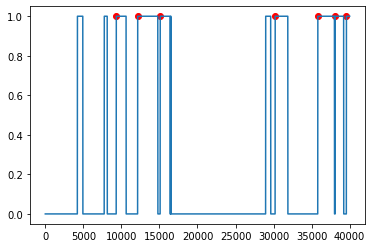

In [331]:

plt.plot(h[:2*20000])
plt.scatter(idx_up_h_50[idx_up_h_50<2*20000],h[:2*20000][idx_up_h_50[idx_up_h_50<2*20000]],c='r')

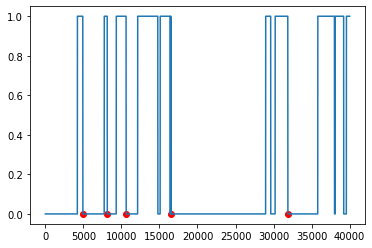

In [105]:
plt.plot(h[:2*20000])
plt.scatter(idx_down_h_50[idx_down_h_50<2*20000],h[:2*20000][idx_down_h_50[idx_down_h_50<2*20000]],c='r')

In [316]:

def return_frs(idx_up,idx_down,frs,I,binary_spikes,time):
    Is_up = []
    frs_up = []
    Is_down = []
    frs_down = []

    bspikes_up = []
    bspikes_down = []


    for i in idx_up:
        Is_up.append(I[i:i+time*20])
    for i in idx_down:
        Is_down.append(I[i:i+time*20])

    for i in idx_up:
        bspikes_up.append(binary_spikes[i:i+time*20])
    for i in idx_down:
        bspikes_down.append(binary_spikes[i:i+time*20])

    for j in range(len(frs)):
        frs_up_temp =[]
        frs_down_temp =[]
        for i in idx_up:
            frs_up_temp.append(np.hstack(frs[j][i:i+time*20]))
        frs_up.append(frs_up_temp)
        for i in idx_down:
            frs_down_temp.append(np.hstack(frs[j][i:i+time*20]))
        frs_down.append(frs_down_temp)
    return Is_up,frs_up,Is_down,frs_down,bspikes_up,bspikes_down

[Is_up_50  ,frs_up_50,  Is_down_50,  frs_down_50,  bspikes_up_50,  bspikes_down_50]  = return_frs(idx_up_h_50,  idx_down_h_50,  fr_convs_exps, I, binary_spikes_nan, 50)
[Is_up_100 ,frs_up_100, Is_down_100, frs_down_100, bspikes_up_100, bspikes_down_100] = return_frs(idx_up_h_100, idx_down_h_100, fr_convs_exps, I, binary_spikes_nan, 100)
[Is_up_500 ,frs_up_500, Is_down_500, frs_down_500, bspikes_up_500, bspikes_down_500] = return_frs(idx_up_h_500, idx_down_h_500, fr_convs_exps, I, binary_spikes_nan, 500)

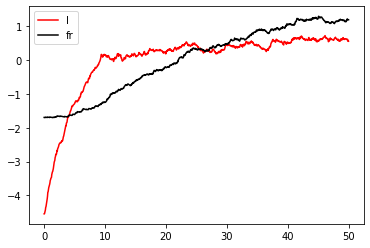

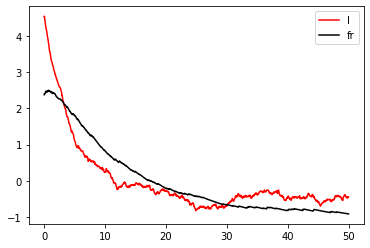

In [315]:
def STA(data):
    return np.mean(np.array(data),axis=0)
x = np.linspace(0,50,50*20)

plt.plot(x,standardize(np.mean(np.array(Is_up_50),axis=0)),c='r')
plt.plot(x,standardize(np.mean(np.array(frs_up_50[0]),axis=0)),c='black')
plt.legend(['I','fr'])
plt.show()
plt.plot(x,standardize(np.mean(np.array(Is_down_50),axis=0)),c='r')
plt.plot(x,standardize(np.mean(np.array(frs_down_50[0]),axis=0)),c='black')
plt.legend(['I','fr'])
plt.show()

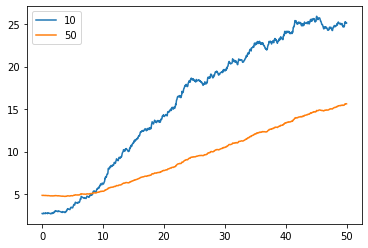

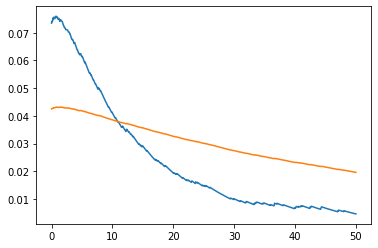

In [313]:
x = np.linspace(0,50,50*20)
for i in range(len(frs_up_50[:2])):
    plt.plot(x,STA(frs_up_50[i]))
plt.legend([10,50,100])
plt.show()
for i in range(len(frs_down_50[:2])):
    plt.plot(x,STA(frs_down_50[i])/np.linalg.norm(STA(frs_down_50[i])))
plt.show()

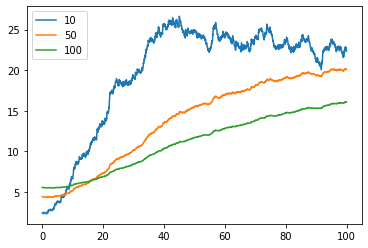

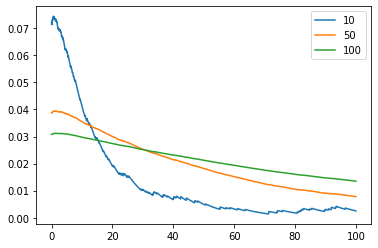

In [77]:
x = np.linspace(0,100,100*20)

for i in range(len(frs_up_100[:3])):
    plt.plot(x,STA(frs_up_100[i]))
plt.legend([10,50,100])
plt.show()
for i in range(len(frs_down_100[:3])):
    plt.plot(x, STA(frs_down_100[i])/np.linalg.norm(STA(frs_down_100[i])))
    plt.legend([10,50,100])
plt.show()




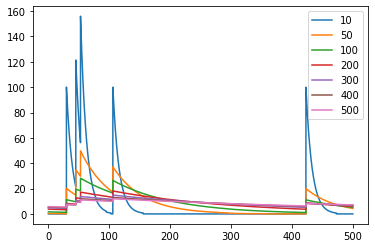

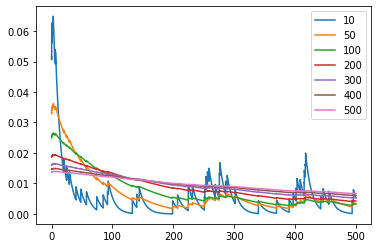

In [78]:
x = np.linspace(0,500,500*20)

for i in range(len(frs_up_500)):
    plt.plot(x,STA(frs_up_500[i]))
plt.legend([10,50,100,200,300,400,500])
plt.show()

for i in range(len(frs_down_500)):
    plt.plot(x, STA(frs_down_500[i])/np.linalg.norm(STA(frs_down_500[i])))
plt.legend([10,50,100,200,300,400,500])
plt.show()




In [228]:
idx_up_h_50_first = idx_up_h_50[idx_up_h_50<180*20000]
idx_up_h_50_second = idx_up_h_50[idx_up_h_50>180*20000]

idx_down_h_50_first = idx_down_h_50[idx_down_h_50<180*20000]
idx_down_h_50_second = idx_down_h_50[idx_down_h_50>180*20000]

idx_up_h_100_first = idx_up_h_100[idx_up_h_100<180*20000]
idx_up_h_100_second = idx_up_h_100[idx_up_h_100>180*20000]

idx_down_h_100_first = idx_down_h_100[idx_down_h_100<180*20000]
idx_down_h_100_second = idx_down_h_100[idx_down_h_100>180*20000]


Is_up_first,frs_up_first,Is_down_first,frs_down_first,bspikes_up_first,bspikes_down_first = return_frs(idx_up_h_50_first,idx_down_h_50_first,fr_convs_exps,I,binary_spikes_nan,50)
Is_up_second,frs_up_second,Is_down_second,frs_down_second,bspikes_up_second,bspikes_down_second = return_frs(idx_up_h_50_second,idx_down_h_50_second,fr_convs_exps,I,binary_spikes_nan,50)


In [235]:
def normalize_STA_up(data):
    a = np.max(data[:])
    b = data[0]
    return (data-b)/(a-b)

def normalize_STA_down(data):
    a = np.min(data[:])
    b = data[0]
    return (data-b)/(b-a)

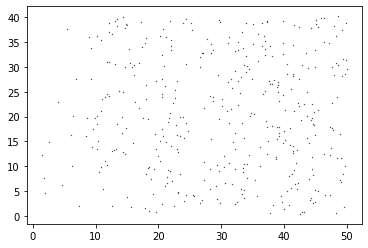

In [230]:
x = np.linspace(0,50,50*20)
count=1
for i in bspikes_up_first:
    count+=1
    plt.scatter(x,i*count/10,s=0.1,c='black')

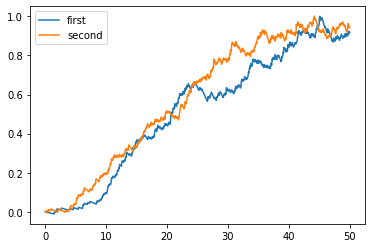

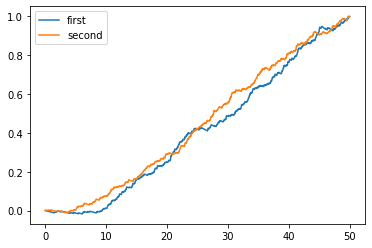

In [231]:
x = np.linspace(0,50,50*20)
plt.plot(x,normalize_STA(STA(frs_up_first[0])))
plt.plot(x,normalize_STA(STA(frs_up_second[0])))
plt.legend(['first','second'])
plt.show()

plt.plot(x,normalize_STA(STA(frs_up_first[1])))
plt.plot(x,normalize_STA(STA(frs_up_second[1])))
plt.legend(['first','second'])
plt.show()



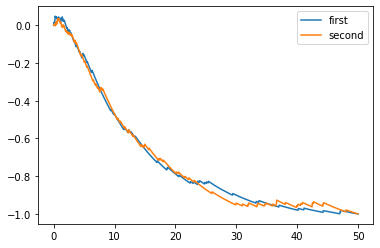

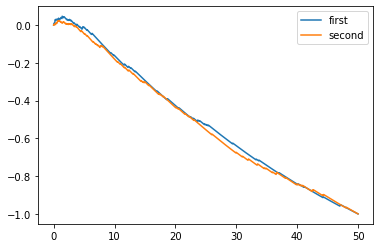

In [236]:
x = np.linspace(0,50,50*20)
plt.plot(x,normalize_STA_down(STA(frs_down_first[0])))
plt.plot(x,normalize_STA_down(STA(frs_down_second[0])))
plt.legend(['first','second'])
plt.show()

plt.plot(x,normalize_STA_down(STA(frs_down_first[1])))
plt.plot(x,normalize_STA_down(STA(frs_down_second[1])))
plt.legend(['first','second'])
plt.show()


In [238]:

Is_up_first,frs_up_first,Is_down_first,frs_down_first,bspikes_up_first,bspikes_down_first = return_frs(idx_up_h_100_first,idx_down_h_100_first,fr_convs_exps,I,binary_spikes_nan,100)
Is_up_second,frs_up_second,Is_down_second,frs_down_second,bspikes_up_second,bspikes_down_second = return_frs(idx_up_h_100_second,idx_down_h_100_second,fr_convs_exps,I,binary_spikes_nan,100)


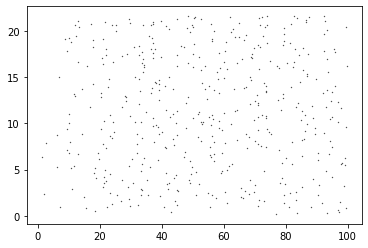

In [202]:
x = np.linspace(0,100,100*20+1)
count=1
for i in bspikes_up_first:
    count+=1
    plt.scatter(x,i*count/10,s=0.1,c='black')

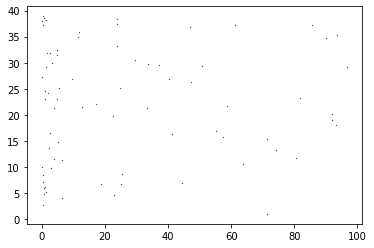

In [225]:
x = np.linspace(0,100,100*20)
count=1
for i in bspikes_down_first:
    count+=1
    plt.scatter(x,i*count/10,s=0.1,c='black')

In [603]:
# np.histogram(np.nansum(bspikes_up_first,axis=0),bins=100,range=[0,100])

import numpy as np
from scipy.stats import binned_statistic

data = np.nansum(bspikes_up_first,axis=0)


array([0., 0., 0., ..., 0., 0., 0.])

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.000e+00, 5.000e-02, 1.000e-01, ..., 9.990e+01, 9.995e+01,
        1.000e+02]),
 <BarContainer object of 2000 artists>)

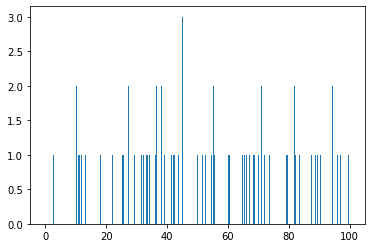

In [588]:
x = np.linspace(0,100,100*20+1)
plt.hist(x[:-1],x,weights= np.nansum(bspikes_up_first,axis=0),histtype='bar')



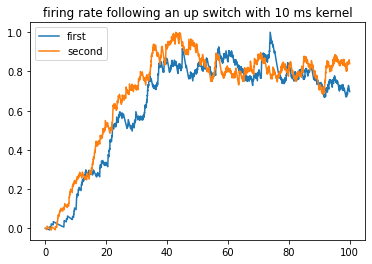

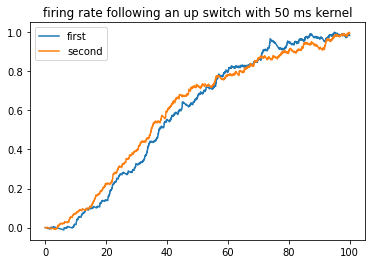

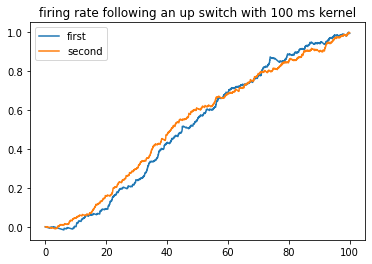

In [239]:
x = np.linspace(0,100,100*20)

plt.plot(x,normalize_STA_up(STA(frs_up_first[0])))
plt.plot(x,normalize_STA_up(STA(frs_up_second[0])))
plt.legend(['first','second'])
plt.title('firing rate following an up switch with 10 ms kernel')
plt.show()

plt.plot(x,normalize_STA_up(STA(frs_up_first[1])))
plt.plot(x,normalize_STA_up(STA(frs_up_second[1])))
plt.legend(['first','second'])
plt.title('firing rate following an up switch with 50 ms kernel')
plt.show()

plt.plot(x,normalize_STA_up(STA(frs_up_first[2])))
plt.plot(x,normalize_STA_up(STA(frs_up_second[2])))
plt.legend(['first','second'])
plt.title('firing rate following an up switch with 100 ms kernel')
plt.show()

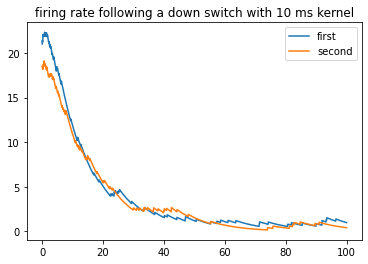

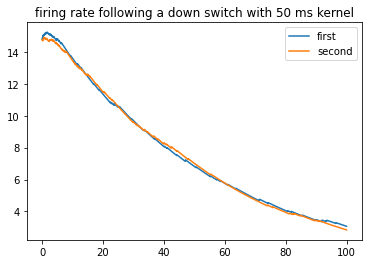

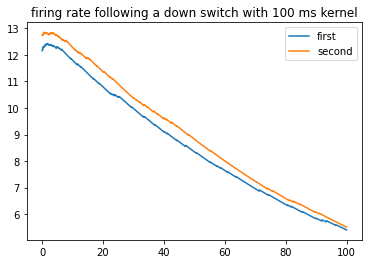

In [108]:
x = np.linspace(0,100,100*20)
plt.plot(x,normalize_STA_down(STA(frs_down_first[0])))
plt.plot(x,normalize_STA_down(STA(frs_down_second[0])))
plt.legend(['first','second'])
plt.title('firing rate following a down switch with 10 ms kernel')
plt.show()

plt.plot(x,normalize_STA_down(STA(frs_down_first[1])))
plt.plot(x,normalize_STA_down(STA(frs_down_second[1])))
plt.legend(['first','second'])
plt.title('firing rate following a down switch with 50 ms kernel')
plt.show()


plt.plot(x,normalize_STA_down(STA(frs_down_first[2])))
plt.plot(x,normalize_STA_down(STA(frs_down_second[2])))
plt.legend(['first','second'])
plt.title('firing rate following a down switch with 100 ms kernel')
plt.show()


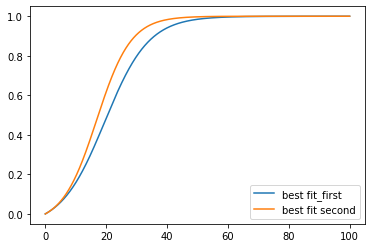

In [305]:

from lmfit import Model

x1 = np.linspace(0,100,100*20)
y1 = normalize_STA_up(STA(frs_up_first[0]))

x2 = np.linspace(0,100,100*20)
y2 = normalize_STA_up(STA(frs_up_second[0]))

def sigmoid (x, A, h, slope, C):
    return 1 / (1 + np.exp ((x - h) / slope)) *  A + C


gmodel1 = Model(sigmoid)
result1 = gmodel.fit(y1, x=x1, A=10, h= 1, slope=0.2, C=1)

gmodel2 = Model(sigmoid)
result2 = gmodel.fit(y2, x=x2, A=10, h= 1, slope=0.2, C=1)

# print(result.fit_report())

# plt.plot(x1, y1, 'o')
# plt.plot(x2, y2, 'o')

# plt.plot(x, result.init_fit, '--', label='initial fit')
plt.plot(x, normalize_STA_up(result1.best_fit), '-', label='best fit_first')
plt.plot(x, normalize_STA_up(result2.best_fit), '-', label='best fit second')

plt.legend()
plt.show()
# <end examples/doc_model_gaussian.py>

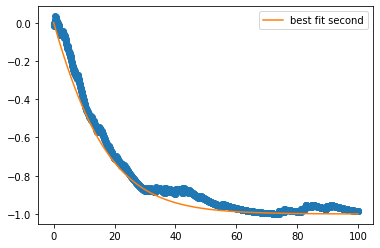

In [308]:
y1 = normalize_STA_down(STA(frs_down_first[0]))

x2 = np.linspace(0,100,100*20)
y2 = normalize_STA_down(STA(frs_down_second[0]))

def sigmoid (x, A, h, slope, C):
    return 1 / (1 + np.exp ((x - h) / slope)) *  A + C


gmodel1 = Model(sigmoid)
result1 = gmodel.fit(y1, x=x1, A=10, h= 1, slope=0.2, C=1)

gmodel2 = Model(sigmoid)
result2 = gmodel.fit(y2, x=x2, A=10, h= 1, slope=0.2, C=1)

# print(result.fit_report())

# plt.plot(x1, y1, 'o')
plt.plot(x2, y2, 'o')

# plt.plot(x, result.init_fit, '--', label='initial fit')
# plt.plot(x, normalize_STA_down(result1.best_fit), '-', label='best fit_first')
plt.plot(x, normalize_STA_down(result2.best_fit), '-', label='best fit second')

plt.legend()
plt.show()
# <end examples/doc_model_gaussian.py>

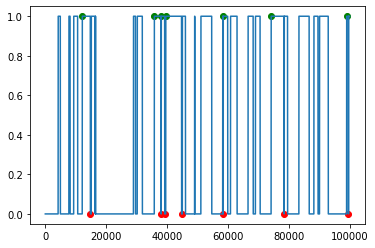

In [472]:
# corresponding_ups
final_down_idx = downs[idx_short_downs[long_up_idx]]
final_ups_idx = ups[idx_short_downs[long_up_idx]]

time  = 5*20000 
x = np.linspace(0,10,time)
plt.plot(h[:time])
plt.scatter(final_down_idx[final_down_idx<time],h[:time][final_down_idx[final_down_idx<time]],c='r')
plt.scatter(final_ups_idx[final_ups_idx<time],h[:time][final_ups_idx[final_ups_idx<time]],c='green')


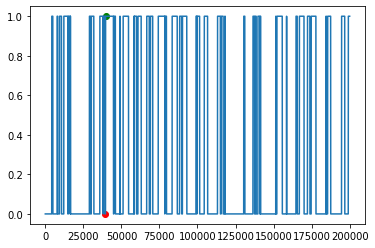

In [584]:
idx_short_downs = np.where(down_durations<20)[0] #gives the indicies for short down duration
corresponding_ups = up_durations[1:][idx_short_downs] # this gives the previous up durations
long_up_idx = np.where((corresponding_ups>200))[0]

# corresponding_ups[long_up_idx]
idx_with_short_downs = downs[idx_short_downs[long_up_idx]]
idx_with_long_ups_with_short_downs = ups[1:][idx_short_downs[long_up_idx]]

time  = 10*20000 
x = np.linspace(0,10,time)
plt.plot(h[:time])
plt.scatter(idx_with_short_downs[idx_with_short_downs<time],h[:time][idx_with_short_downs[idx_with_short_downs<time]],c='r')
plt.scatter(idx_with_long_ups_with_short_downs[idx_with_long_ups_with_short_downs<time],h[:time][idx_with_long_ups_with_short_downs[idx_with_long_ups_with_short_downs<time]],c='green')

h_temp = []
I_temp = []
fr_temp = []

for i in idx_with_long_ups_with_short_downs:
    h_temp.append(h[i-(20*20):i+(180*20)])
    I_temp.append(I[i-(20*20):i+(180*20)])
    fr_temp.append(fr_convs_exps[0][i-(20*20):i+(180*20)])


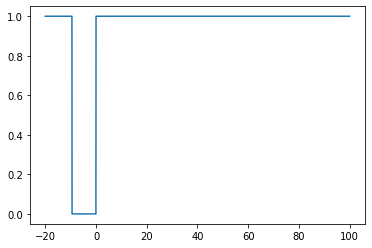

In [585]:
# plt.plot(x, STA(h_temp))
x = np.linspace(-20,100,120*20)
plt.plot(x, h[idx_with_long_ups_with_short_downs[11]-20*20:idx_with_long_ups_with_short_downs[11]+100*20])

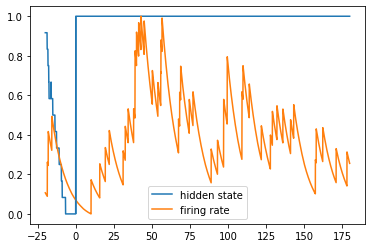

In [586]:
def norm_temp(data):
    a = np.max(data)
    b = np.min(data)
    return (data-b)/(a-b)
x = np.linspace(-20,180,200*20)
plt.plot(x, STA(h_temp))
plt.plot(x, norm_temp(STA(fr_temp)))
# plt.plot(x, norm_temp(STA(I_temp)))
plt.legend(['hidden state','firing rate','Input'])
plt.vlines(0,0,1)    

# plt.plot(x, STA(I_temp))

# Excitatory Cells

In [13]:
path = "G:/My Drive/Analyzed/NC_170815_aCSF_D1ago_E2_analyzed.mat"
data = loadmatInPy(path)

In [14]:

time = 360*20000
x_total = np.linspace(0,360,360*20000)
h = data[0]['hidden_state'][:]
I = data[0]['input_current'][:]
spikes = data[0]['spikeindices'][:]
V = data[0]['membrane_potential'][:]

binary_spikes = np.zeros_like(V)
binary_spikes[spikes] = 1

binary_spikes_nan = np.zeros_like(V)*np.nan
binary_spikes_nan[spikes] = 1


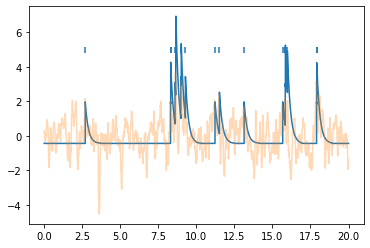

In [143]:
def standardize(data):
    return (data-np.mean(data))/np.std(data)

input_smooth = smooth_gaussian(I,100*20)
fr_exps = smooth_exp(spikes,200)
plt.plot(np.linspace(0,20,20*20000),standardize(fr_exps[:20000*20]))
plt.plot(np.linspace(0,20,20*20000),standardize(input_smooth[:20000*20]),alpha=0.3)
plt.scatter(np.linspace(0,20,20*20000),binary_spikes_nan[:20000*20]*5,marker="|")


In [9]:
cust_time_winds = [10,50, np.arange(100,500,100)]
cust_time_winds = np.hstack(cust_time_winds)

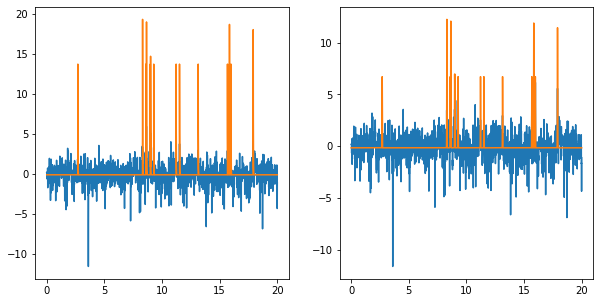

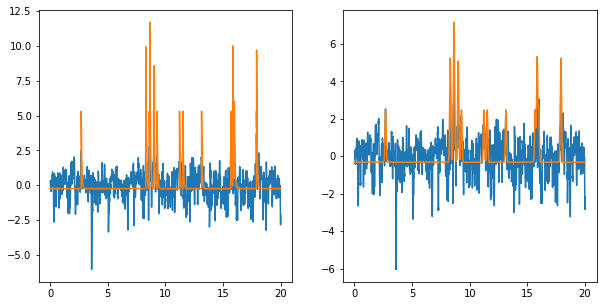

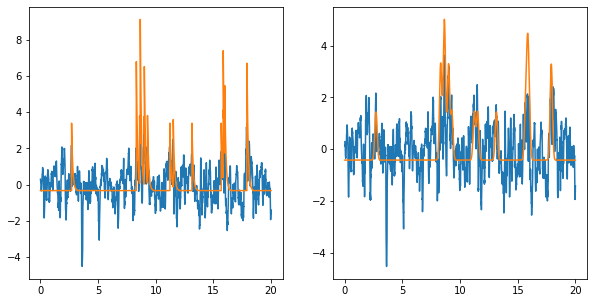

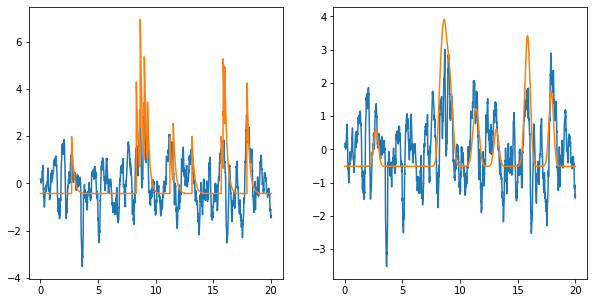

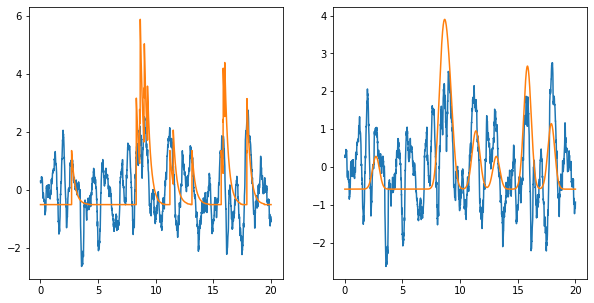

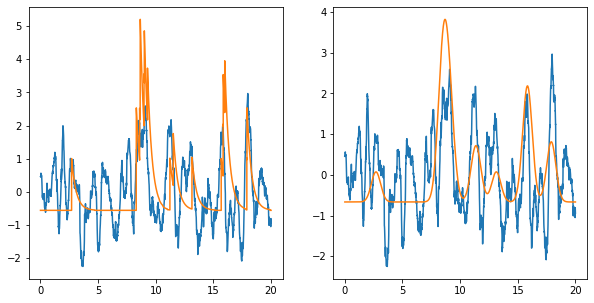

In [16]:
def standardize(data):
    return (data-np.mean(data))/np.std(data)
def normalize(data):
    return data/np.linalg.norm(data)

I_convs = []
fr_convs_exps = []
fr_convs_gaussian = []
h_convs = []

for i in cust_time_winds:
    
    fig,[ax1,ax2] = plt.subplots(1,2,figsize=[10,5])
    box_size = i*20
    spikes_smooth = smooth_exp(spikes,i)
    spikes_smooth_g = smooth_gaussian_e(spikes,i)

    input_smooth = smooth_gaussian(I,box_size)
    h_smooth = smooth_gaussian(h,box_size)

    I_convs.append(input_smooth)
    fr_convs_exps.append(spikes_smooth)
    fr_convs_gaussian.append(spikes_smooth)
    h_convs.append(h_smooth)
    
    x = np.linspace(0,20,20*20000)

    ax1.plot(x,standardize(input_smooth[:20*20000]))
    ax1.plot(x,standardize(spikes_smooth[:20*20000]))
    ax2.plot(x,standardize(input_smooth[:20*20000]))
    ax2.plot(x,standardize(spikes_smooth_g[:20*20000]))    
    plt.show()

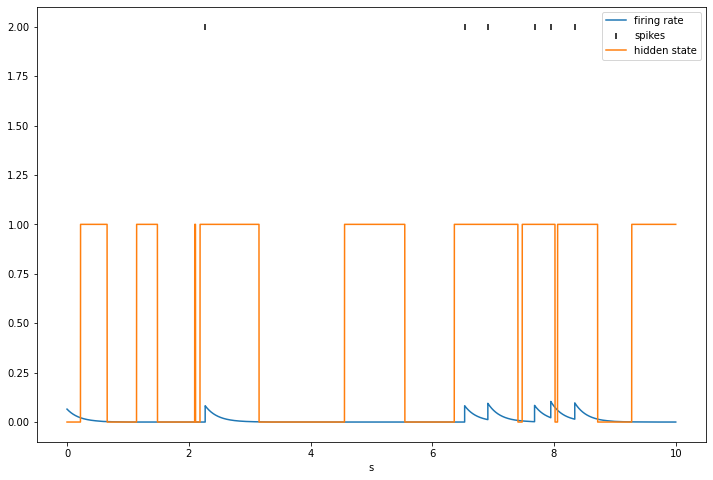

In [27]:
time = 10
x = np.linspace(0,time,time*20000)
plt.figure(figsize=[12,8])
plt.plot(x,normalize(fr_convs_exps[3])[-time*20000:]*100)
plt.scatter(x,binary_spikes_nan[-time*20000:]*2,c='black',marker="|")
plt.plot(x,h[-time*20000:])
plt.legend(['firing rate','spikes','hidden state'],)
plt.xlabel('s')
plt.show()

filter duration 10 ms


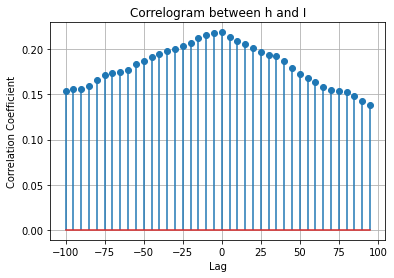

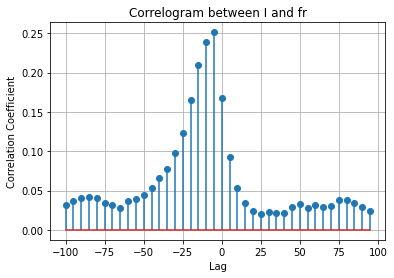

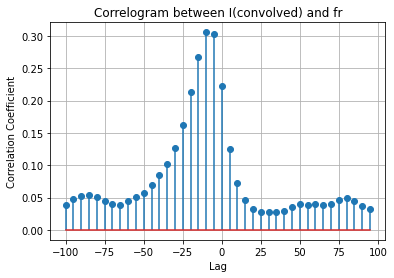

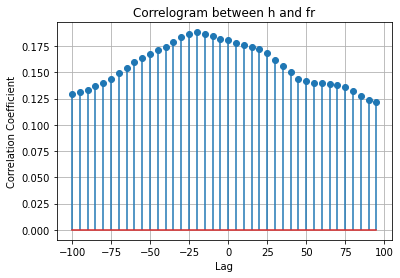

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Sample signals (replace with your actual data)
def plot_correlations(sig1,sig2,tau,str1,str2,ax):
    signal1 = sig1-np.mean(sig1)
    signal2 = sig2-np.mean(sig2)
    # Calculate cross-correlation with maximum lag of 20
    correlation = signal.correlate(signal1, signal2 , mode='full')
    correlation /= np.sqrt(np.sum(signal1**2)*np.sum(signal2**2))    
    lags = signal.correlation_lags(len(signal1), len(signal1))

    # Plot the correlogram
    # lags = np.arange(-tau,tau,1/20)
    # plt.stem(lags[::100], correlation[len(correlation)//2-tau*20:len(correlation)//2+tau*20][::100])
    ax.stem(lags[len(lags)//2-100*20:len(lags)//2+100*20:100]/20, correlation[len(lags)//2-100*20:len(lags)//2+100*20:100])

    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Correlogram between {str1} and {str2}')
    ax.grid(True)
    # plt.show()

print('filter duration '+str(10)+' ms')

# plot_correlations()
time_t = 50
fig,ax = plt.subplots()
plot_correlations(h[:time_t*20000],I[:time_t*20000],100,'h','I',ax)
fig,ax = plt.subplots()
plot_correlations(I[:time_t*20000],np.hstack(fr_convs_exps[0][:time_t*20000]),100,'I','fr',ax)
fig,ax = plt.subplots()
plot_correlations(I_convs[0][:time_t*20000],np.hstack(fr_convs_exps[0][:time_t*20000]),100,'I(convolved)','fr',ax)
fig,ax = plt.subplots()
plot_correlations(h[:time_t*20000],np.hstack(fr_convs_exps[0][:time_t*20000]),100,'h','fr',ax)

# plot_correlations(h[:10*20000],I[:10*20000],100,'h','I')

filter duration 10 ms


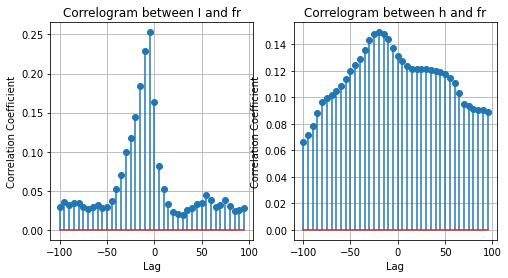

filter duration 50 ms


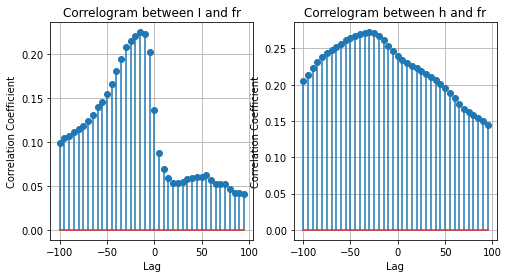

filter duration 100 ms


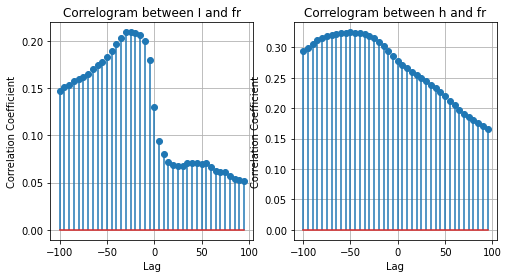

filter duration 200 ms


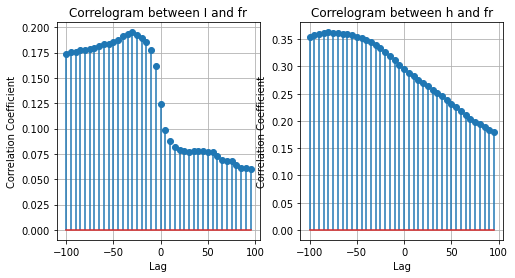

filter duration 300 ms


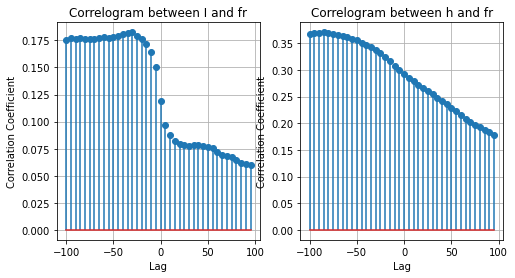

filter duration 400 ms


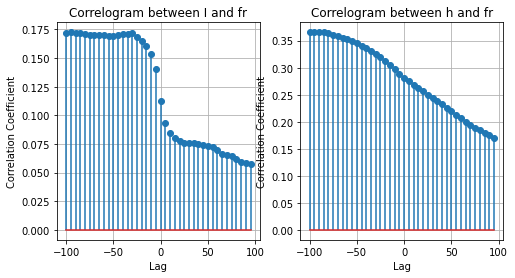

In [32]:
time_t = 50
for i in range(len(fr_convs_exps)):
    print('filter duration '+str(cust_time_winds[i])+' ms')
    fig,[ax1,ax2] = plt.subplots(1,2,figsize=[8,4])
    plot_correlations(I[-time_t*20000:],np.hstack(fr_convs_exps[i][-time_t*20000:]),100,'I','fr',ax1)
    # plot_correlations(I_convs[0][-time_t*20000:],np.hstack(fr_convs_exps[0][-time_t*20000:]),100,'I(convolved)','fr')
    plot_correlations(h[-time_t*20000:],np.hstack(fr_convs_exps[i][-time_t*20000:]),100,'h','fr',ax2)
    plt.show()

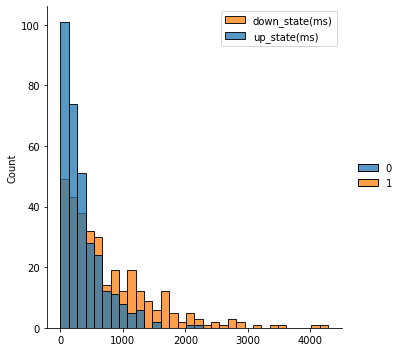

In [31]:
h = np.array(h,dtype=np.int32)
ups = np.where(np.diff(h)==1)[0]+1
downs = np.where(np.diff(h)==-1)[0]+1

up_durations = (downs-ups[:-1])/20
down_durations = (ups[1:] - downs)/20

sns.displot([up_durations,down_durations],log_scale=False,kind='hist')
plt.legend(['down_state(ms)','up_state(ms)'])
# sns.displot(,log_scale=False,kind='hist')

In [39]:
idx_up_h_10 = ups[np.where(up_durations>10)]
idx_down_h_10 = downs[np.where(down_durations>10)]

idx_up_h_50 = ups[np.where(up_durations>50)]
idx_down_h_50 = downs[np.where(down_durations>50)]

idx_up_h_100 = ups[np.where(up_durations>100)]
idx_down_h_100 = downs[np.where(down_durations>100)]

idx_up_h_200 = ups[np.where(up_durations>200)]
idx_down_h_200 = downs[np.where(down_durations>200)]


In [40]:

def return_frs(idx_up,idx_down,frs,I,binary_spikes,time):
    Is_up = []
    frs_up = []
    Is_down = []
    frs_down = []

    bspikes_up = []
    bspikes_down = []


    for i in idx_up:
        Is_up.append(I[i:i+time*20])
    for i in idx_down:
        Is_down.append(I[i:i+time*20])

    for i in idx_up:
        bspikes_up.append(binary_spikes[i:i+time*20])
    for i in idx_down:
        bspikes_down.append(binary_spikes[i:i+time*20])

    for j in range(len(frs)):
        frs_up_temp =[]
        frs_down_temp =[]
        for i in idx_up:
            frs_up_temp.append(np.hstack(frs[j][i:i+time*20]))
        frs_up.append(frs_up_temp)
        for i in idx_down:
            frs_down_temp.append(np.hstack(frs[j][i:i+time*20]))
        frs_down.append(frs_down_temp)
    return Is_up,frs_up,Is_down,frs_down,bspikes_up,bspikes_down

[Is_up_10  ,frs_up_10,  Is_down_10,  frs_down_10,  bspikes_up_10,  bspikes_down_10]  = return_frs(idx_up_h_10,  idx_down_h_10,  fr_convs_exps, I, binary_spikes_nan, 10)
[Is_up_50  ,frs_up_50,  Is_down_50,  frs_down_50,  bspikes_up_50,  bspikes_down_50]  = return_frs(idx_up_h_50,  idx_down_h_50,  fr_convs_exps, I, binary_spikes_nan, 50)
[Is_up_100 ,frs_up_100, Is_down_100, frs_down_100, bspikes_up_100, bspikes_down_100] = return_frs(idx_up_h_100, idx_down_h_100, fr_convs_exps, I, binary_spikes_nan, 100)
[Is_up_200 ,frs_up_200, Is_down_200, frs_down_200, bspikes_up_200, bspikes_down_200] = return_frs(idx_up_h_200, idx_down_h_200, fr_convs_exps, I, binary_spikes_nan, 200)

In [151]:
def STA(data):
    return np.mean(np.array(data),axis=0)

def normalize_STA_up(data):
    a = np.max(data)
    b = data[0]
    return (data-b)/(a-b)

def normalize_STA_down(data):
    a = np.min(data)
    b = np.max(data)
    return (data-a)/(b-a)

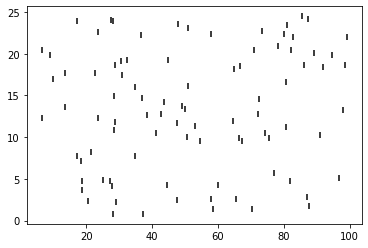

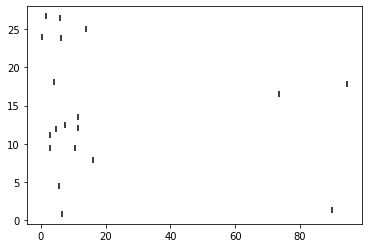

In [89]:

x = np.linspace(0,100,100*20)
count=1
for i in bspikes_up_100:
    count+=1
    plt.scatter(x,i*count/10,c='black',marker='|')
plt.show()
x = np.linspace(0,100,100*20)
count=1
for i in bspikes_down_100:
    count+=1
    plt.scatter(x,i*count/10,c='black',marker='|')


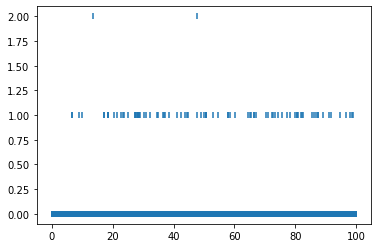

In [100]:
x = np.linspace(0,100,100*20)
plt.scatter(x, np.nansum(bspikes_up_100,axis=0),marker='|')

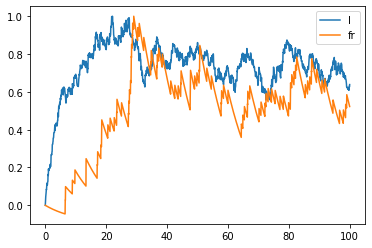

In [107]:
x = np.linspace(0,100,100*20)

plt.plot(x,normalize_STA_up(STA(Is_up_100)))
plt.plot(x,normalize_STA_up(STA(frs_up_100[0])))
plt.legend(['I','fr'])
plt.show()



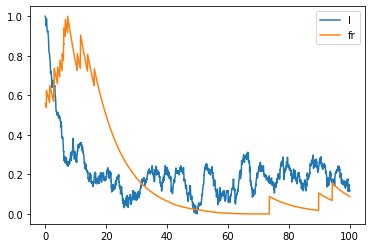

In [153]:
x = np.linspace(0,100,100*20)

plt.plot(x,normalize_STA_down(STA(Is_down_100)),linee)
plt.plot(x,normalize_STA_down(STA(frs_down_100[0])))
plt.legend(['I','fr'])
plt.show()


400

In [1]:
x = np.linspace(0,200,200*20)
for i in range(len(frs_up_200)):
    # plt.plot(x,normalize_STA_up(STA(Is_up_200)))
    plt.plot(x,normalize_STA_up(STA(frs_up_200[i])))
    plt.legend(cust_time_winds)
    # plt.show()


NameError: name 'np' is not defined

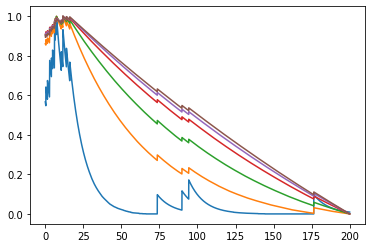

In [154]:
x = np.linspace(0,200,200*20)
for i in range(len(frs_down_200)):
    # plt.plot(x,normalize_STA_down(STA(Is_down_200)))
    plt.plot(x,normalize_STA_down(STA(frs_down_200[i])))
    # plt.legend(['I','fr'])
    # plt.show()
